In [46]:
from __future__ import print_function
import urllib
import bz2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.image as mpimg
import cv2
import plotly.graph_objs as go
import os
from utils.utils_IO import ordered_arr_3d_to_dict, refill_nan_array, arr_2d_to_list_of_dicts, read_image, make_image_array, revert_ordered_arr_2d_to_dict, save_object
from utils.utils_plotting import plot_image_labels, plot_3d_points, vector_plot, draw_circles, slope, drawLine, skew
from utils.utils_BA import fun, bundle_adjustment_sparsity, project
from anipose_BA import CameraGroup, Camera
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
TOP_IMG_HEIGHT=168
BOT_IMG_HEIGHT=238
IMG_WIDTH= 396
P_X_BOT = P_X_TOP = IMG_WIDTH // 2
P_Y_BOT = BOT_IMG_HEIGHT // 2
P_Y_TOP = TOP_IMG_HEIGHT // 2
#(Camera, Coordinates)
#OFFSET = np.asarray([[P_Y_TOP, P_X_TOP], [P_Y_BOT, P_X_BOT]])
OFFSET = np.asarray([[P_X_TOP, P_Y_TOP], [P_X_BOT, P_Y_BOT]])

In [48]:
print(os.getcwd())
data_folder = 'mouseRunningData'

/Users/Sunsmeister/Desktop/Research/Brain/MultiView/3D-Animal-Pose


In [49]:
DLC_dframe = pd.read_csv(data_folder + '/CollectedData_.csv', 
                         header = [1,2]) 
# header = [1,2] is important. Provides a hierarchical data frame
DLC_dframe.head() # inspect
#DLC_dframe['paw1LH_top','x'] # that's how you index.

bodyparts paw1LH_top         paw2LF_top              \
                         coords          x       y          x           y   
0  barObstacleScaling1/img1.png      77.25   36.25     253.50  101.900393   
1  barObstacleScaling1/img2.png      37.25  110.75     285.75  104.750000   
2  barObstacleScaling1/img3.png     123.25  110.25     325.25  114.750000   
3  barObstacleScaling1/img4.png     125.25  106.75     230.25   51.250000   
4  barObstacleScaling1/img5.png      67.75   98.25     269.75  103.250000   

  paw3RF_top         paw4RH_top         tailBase_top  ... tailBase_bot  \
           x       y          x       y            x  ...            x   
0     198.75   97.75     182.25   63.75          NaN  ...        84.75   
1     253.25  101.75      46.75  129.75        49.25  ...        54.25   
2     279.25  103.25      39.75  143.75          NaN  ...        74.75   
3     317.75  113.25      70.25  123.25        55.75  ...        77.25   
4     305.75   96.25      29.25   72.75        65.25  ...        82.75   

          tailMid_bot         nose_bot         obsHigh_bot         obsLow_bot  \
        y           x       y        x       y           x       y          x   
0  329.75       46.25  332.75   381.25  281.75       74.25  184.25      74.75   
1  304.75       27.25  313.75   382.25  282.25      121.25  184.75     118.75   
2  318.25       34.75  389.75   383.25  280.75      236.25  198.25     234.75   
3  309.75       32.75  317.75   383.25  280.25      222.25  198.75     213.75   
4  323.25       35.75  339.25   381.75  280.25      116.25  192.25     112.25   

           
        y  
0  386.25  
1  385.75  
2  381.75  
3  380.25  
4  381.25  

[5 rows x 35 columns]

In [50]:
# change the bodyparts, coords entries.
DLC_dframe = DLC_dframe.rename(columns = { \
    "bodyparts":"img_name", "coords":"img_name" })
DLC_dframe.head()

img_name paw1LH_top         paw2LF_top              \
                       img_name          x       y          x           y   
0  barObstacleScaling1/img1.png      77.25   36.25     253.50  101.900393   
1  barObstacleScaling1/img2.png      37.25  110.75     285.75  104.750000   
2  barObstacleScaling1/img3.png     123.25  110.25     325.25  114.750000   
3  barObstacleScaling1/img4.png     125.25  106.75     230.25   51.250000   
4  barObstacleScaling1/img5.png      67.75   98.25     269.75  103.250000   

  paw3RF_top         paw4RH_top         tailBase_top  ... tailBase_bot  \
           x       y          x       y            x  ...            x   
0     198.75   97.75     182.25   63.75          NaN  ...        84.75   
1     253.25  101.75      46.75  129.75        49.25  ...        54.25   
2     279.25  103.25      39.75  143.75          NaN  ...        74.75   
3     317.75  113.25      70.25  123.25        55.75  ...        77.25   
4     305.75   96.25      29.25   72.75        65.25  ...        82.75   

          tailMid_bot         nose_bot         obsHigh_bot         obsLow_bot  \
        y           x       y        x       y           x       y          x   
0  329.75       46.25  332.75   381.25  281.75       74.25  184.25      74.75   
1  304.75       27.25  313.75   382.25  282.25      121.25  184.75     118.75   
2  318.25       34.75  389.75   383.25  280.75      236.25  198.25     234.75   
3  309.75       32.75  317.75   383.25  280.25      222.25  198.75     213.75   
4  323.25       35.75  339.25   381.75  280.25      116.25  192.25     112.25   

           
        y  
0  386.25  
1  385.75  
2  381.75  
3  380.25  
4  381.25  

[5 rows x 35 columns]

In [51]:
bodyparts = list(DLC_dframe.columns.levels[0][1:]) # [1:] to remove img name
print(bodyparts)

['nose_bot', 'nose_top', 'obsHigh_bot', 'obsLow_bot', 'obs_top', 'paw1LH_bot', 'paw1LH_top', 'paw2LF_bot', 'paw2LF_top', 'paw3RF_bot', 'paw3RF_top', 'paw4RH_bot', 'paw4RH_top', 'tailBase_bot', 'tailBase_top', 'tailMid_bot', 'tailMid_top']


In [52]:
path_images = data_folder + \
                '/' + \
                DLC_dframe["img_name", "img_name"]\
                .to_numpy()
print(path_images.shape)

(1045,)


In [53]:
im_arr = make_image_array(path_images[0:10], flip = False)

(406, 396, 10)


In [54]:
# pick either all body parts or part of them
#bp2plot = ['nose_bot', 'nose_top', 'tailBase_bot', 'tailBase_top']
bp2plot = bodyparts
pose_2D_dict = {}
pose_2D_dict["x_coords"] = DLC_dframe.loc[: , (bp2plot , 'x')].to_numpy() # DLC_dframe[bp2plot]
pose_2D_dict["y_coords"] = DLC_dframe.loc[: , (bp2plot , 'y')].to_numpy() # DLC_dframe[bp2plot]

In [55]:
# using https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python
'''just these body parts that are seen from both views.'''
bp2plot = bodyparts
bp_short = []
for i in range(len(bp2plot)):
    if bp2plot[i][:3] != 'obs': # not plotting the obstacle
        bp_short.append(bp2plot[i][:-4]) # last four chars (_top/_bot)

short_list = list(set(bp_short)) # set returns unique elements in list
short_list_bot = []
short_list_top = []
for i in short_list:
    short_list_bot.append(i + '_bot')
    short_list_top.append(i + '_top')

tuple_x= (short_list_top, 'x')
tuple_y= (short_list_top, 'y')
tuple_z = (short_list_bot, 'y') #Remember to negate (right-hand-rule)

Normalizing / Re-mapping coordinates for bottom image

In [56]:
# Treat bottom image separately
# Remap y-values for bottom image
DLC_dframe.loc[: , tuple_z] -= TOP_IMG_HEIGHT

In [57]:
# extract 3d from rick
pose_dict_3d = {}
pose_dict_3d["x_coords"] = DLC_dframe.loc[: , \
                            tuple_x].to_numpy() # DLC_dframe[bp2plot]
pose_dict_3d["y_coords"] = DLC_dframe.loc[: , \
                            tuple_y].to_numpy() #/ DLC_dframe[bp2plot]

pose_dict_3d["z_coords"] = - DLC_dframe.loc[: , \
                           tuple_z].to_numpy()  # DLC_dframe[bp2plot]



In [58]:
# transform to BA format
pts_array_3d = np.hstack([pose_dict_3d["x_coords"].flatten().reshape(-1,1), 
           pose_dict_3d["y_coords"].flatten().reshape(-1,1),
                         pose_dict_3d["z_coords"].flatten().reshape(-1,1)])

print('original number of unique pts was %d' % pts_array_3d.shape[0])
nan_pts_3d = np.isnan(pts_array_3d).any(axis=1) # remove 3d points here and in each view

original number of unique pts was 7315


In [59]:
# removing_nans
print('excluding %d tracked points!' % np.sum(nan_pts_3d==True)) # number of excluded 3d points.
pts_array_3d_clean = pts_array_3d[~nan_pts_3d, :]
pts_all_flat = np.arange(pts_array_3d.shape[0])
clean_point_indices = pts_all_flat[~nan_pts_3d]

#(clean_point_indices == np.where(~nan_pts_3d)).all() # True
info_dict = {}
info_dict["num_frames"] = DLC_dframe.shape[0]
info_dict["num_analyzed_body_parts"] = len(short_list)
info_dict["num_cameras"] = 2
info_dict["num_points_all"] = pts_array_3d.shape[0]
info_dict["clean_point_indices"] = pts_all_flat[~nan_pts_3d]
assert(info_dict["num_points_all"] == 
           info_dict["num_frames"]*info_dict["num_analyzed_body_parts"])

excluding 618 tracked points!


In [60]:
# extract params for BA. assuming all points are visible from the two cameras (even if nans)
# only body parts that are visible in both views
tuple_x_bot = (short_list_bot, 'x')
tuple_y_bot = (short_list_bot, 'y')
tuple_x_top = (short_list_top, 'x')
tuple_y_top = (short_list_top, 'y')

# hstack x,y
pts_array_2d_bot_full = np.hstack([DLC_dframe.loc[: , \
        tuple_x_bot].to_numpy().flatten().reshape(-1,1),
                             DLC_dframe.loc[: , \
        tuple_y_bot].to_numpy().flatten().reshape(-1,1)])

# remove nan_pts_3d rows
pts_array_2d_bot = pts_array_2d_bot_full[~nan_pts_3d, :]

# hstack x,y, and remove nan_pts_3d rows.
pts_array_2d_top_full = np.hstack([DLC_dframe.loc[: , \
        tuple_x_top].to_numpy().flatten().reshape(-1,1),
                             DLC_dframe.loc[: , \
        tuple_y_top].to_numpy().flatten().reshape(-1,1)])

pts_array_2d_top = pts_array_2d_top_full[~nan_pts_3d, :]

print('shape of each 2d pt array is %s and %s' %(
    str(pts_array_2d_bot.shape),
    str(pts_array_2d_top.shape)))

shape of each 2d pt array is (6697, 2) and (6697, 2)


In [61]:
ind_start = 155
ind_end = 160

In [62]:
# we are padding the limits of the axis since some points lie at the border.
pad = 10
lims = {}
lims["x"], lims["y"], lims["z"] = \
        [np.nanmin(pose_dict_3d["x_coords"])-pad, \
         np.nanmax(pose_dict_3d["x_coords"])+pad], \
        [np.nanmin(pose_dict_3d["y_coords"])-pad, \
         np.nanmax(pose_dict_3d["y_coords"])+pad], \
        [np.nanmin(pose_dict_3d["z_coords"])-pad, \
         np.nanmax(pose_dict_3d["z_coords"])+pad]

In [63]:
pts_array_2d = np.concatenate((pts_array_2d_top[np.newaxis,:,:], pts_array_2d_bot[np.newaxis,:,:]), axis=0)
print()

In [64]:
#Initialize camera 1
camera_1 = Camera()
cam1_init_params = np.abs(np.random.rand(8))
cam1_init_params[0:6] = 0
camera_1.set_params(cam1_init_params)

#Initialize camera 2
camera_2 = Camera()
cam2_init_params = np.abs(np.random.rand(8))
cam2_init_params[0:3] = -np.pi/2 * np.array([1, 0, 0])
cam2_init_params[3:6] = [0, -1, 1]

camera_2.set_params(cam2_init_params)

cam_group = CameraGroup(cameras=[camera_1, camera_2])

In [65]:
#Get error before Bundle Adjustment:
f0, points_3d_init = cam_group.get_initial_error(pts_array_2d)

In [66]:
#Run Bundle Adjustment
res, points_3d = cam_group.bundle_adjust(pts_array_2d)

Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2457e+08                                    8.81e+05    
       1              4         4.2434e+08      2.30e+05       2.57e+00       1.20e+06    
       2              5         4.2373e+08      6.14e+05       2.90e+00       3.10e+06    
       3              6         4.2266e+08      1.07e+06       3.24e+00       5.97e+06    
       4              7         4.2033e+08      2.33e+06       2.90e+00       1.46e+07    
       5              8         4.1548e+08      4.85e+06       2.53e+00       3.16e+07    
       6              9         4.0576e+08      9.73e+06       2.28e+00       6.40e+07    
       7             10         3.8667e+08      1.91e+07       2.14e+00       1.25e+08    
       8             11         3.5029e+08      3.64e+07       2.10e+00       2.65e+08    
       9             12         2.8477e+08      6.55e+07       2.12e+00       5.09e+08    
  

In [67]:
#Get projected points
points_proj_1 = camera_1.project(points_3d).squeeze()
points_proj_2 = camera_2.project(points_3d).squeeze()
points_proj = np.concatenate((points_proj_1, points_proj_2), axis=0)
#print(points_3d)
print(camera_1.get_focal_length())
print(camera_2.get_focal_length())


36.12327551825713
3.5708957400083845


In [68]:
plot_folder = 'rick_plots'
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

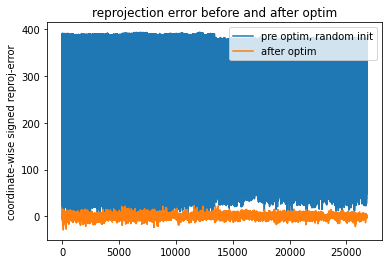

In [69]:
plt.plot(f0, label = 'pre optim, random init')
plt.plot(res.fun, label = 'after optim')
plt.legend()
plt.ylabel('coordinate-wise signed reproj-error')
#plt.xlabel('3 points X 1500 frames X 2 cameras X 2 coords')
plt.title('reprojection error before and after optim')
plt.savefig(os.path.join(plot_folder,'reproj-err-per-frame-initdlc3d.png'))

In [70]:
# now we first refill the full sized containers, then revert to dicts.

# do the pts_array_3d_clean
array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')

    

pose_dict_3d_refill = ordered_arr_3d_to_dict(array_3d_back, info_dict)
# pts_3d_BA
BA_array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
BA_dict = ordered_arr_3d_to_dict(BA_array_3d_back, info_dict)

# pts_2d_orig

pts_array_2d = np.reshape(pts_array_2d, (pts_array_2d.shape[0] * pts_array_2d.shape[1], -1))
array_2d_orig = refill_nan_array(pts_array_2d, 
                              info_dict, 
                               dimension = '2d')

print('array_2d_orig: ', array_2d_orig.shape)
pose_list_2d_orig = arr_2d_to_list_of_dicts(array_2d_orig,
                                              info_dict)
print('pose_list_2d_orig: ', pose_list_2d_orig[0]['x_coords'].shape)
print(len(pose_list_2d_orig))

# pts_2d_reproj
array_2d_reproj_back = refill_nan_array(points_proj, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_reproj = arr_2d_to_list_of_dicts(array_2d_reproj_back,
                                              info_dict)

array_2d_orig:  (14630, 2)
pose_list_2d_orig:  (1045, 7)
2


In [71]:
print('points_3d: ', points_3d.shape)
print('array_3d_back: ', array_3d_back.shape)
print('pose_dict_3d_refill: ', pose_dict_3d_refill['x_coords'].shape)
print('BA_array_3d_back: ', BA_array_3d_back.shape)
print('BA_dict: ', BA_dict['x_coords'].shape)
print('pts_array_2d: ', pts_array_2d.shape)
print('array_2d_orig: ', array_2d_orig.shape)
print('points_proj: ', points_proj.shape)
print('array_2d_reproj_back: ', array_2d_reproj_back.shape)

points_3d:  (6697, 3)
array_3d_back:  (7315, 3)
pose_dict_3d_refill:  (1045, 7)
BA_array_3d_back:  (7315, 3)
BA_dict:  (1045, 7)
pts_array_2d:  (13394, 2)
array_2d_orig:  (14630, 2)
points_proj:  (13394, 2)
array_2d_reproj_back:  (14630, 2)


In [72]:
joined_list_2d = pose_list_2d_orig + pose_list_2d_reproj
len(joined_list_2d)

4

In [73]:
joined_list_3d = []
joined_list_3d.append(pose_dict_3d_refill)
joined_list_3d.append(BA_dict)
len(joined_list_3d)

2

In [74]:
print(np.nanmin(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[1]["x_coords"].flatten()])))
print(np.nanmax(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[1]["x_coords"].flatten()])))

-1.4978887844302666
0.45043476686321116


In [75]:
#Red = ground truth, blue = proj
color_list_2d = ['red', 'red', 'blue', 'blue']
color_list_3d = ['red', 'blue']
# set limits to be the maximum of the two plots
# we are padding the limits of the axis since some points lie at the border.
pad = 1
lims = {}
lims["x"], lims["y"], lims["z"] = \
        [np.nanmin(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[0]["x_coords"].flatten()]))-pad, \
         np.nanmax(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[0]["x_coords"].flatten()])) +pad], \
        [np.nanmin(np.array([joined_list_3d[0]["y_coords"].flatten(), 
          joined_list_3d[0]["y_coords"].flatten()]))-pad, \
         np.nanmax(np.array([joined_list_3d[0]["y_coords"].flatten(), 
          joined_list_3d[0]["y_coords"].flatten()]))+pad], \
        [np.nanmin(np.array([joined_list_3d[0]["z_coords"].flatten(), 
          joined_list_3d[0]["z_coords"].flatten()]))-pad, \
         np.nanmax(np.array([joined_list_3d[0]["z_coords"].flatten(), 
          joined_list_3d[0]["z_coords"].flatten()]))+pad]

In [76]:
#Red = ground truth, blue = proj
color_list_2d = ['red', 'red', 'blue', 'blue']
color_list_3d = ['red', 'blue']
# set limits to be the maximum of the two plots
# we are padding the limits of the axis since some points lie at the border.
pad = 1
lims = {}
lims['x'] = [-0.2, 0.2]
lims['y'] = [-2, 2]
lims['z'] = [0, 1.5]


In [77]:
print(np.nanmax(joined_list_3d[0]['x_coords']))
print(np.nanmax(joined_list_3d[1]['x_coords']))
print(np.nanmax(joined_list_3d[0]['y_coords']))
print(np.nanmax(joined_list_3d[1]['y_coords']))
print(lims)

0.45043476686321116
0.45043476686321116
0.37222521459375574
0.37222521459375574
{'x': [-0.2, 0.2], 'y': [-2, 2], 'z': [0, 1.5]}


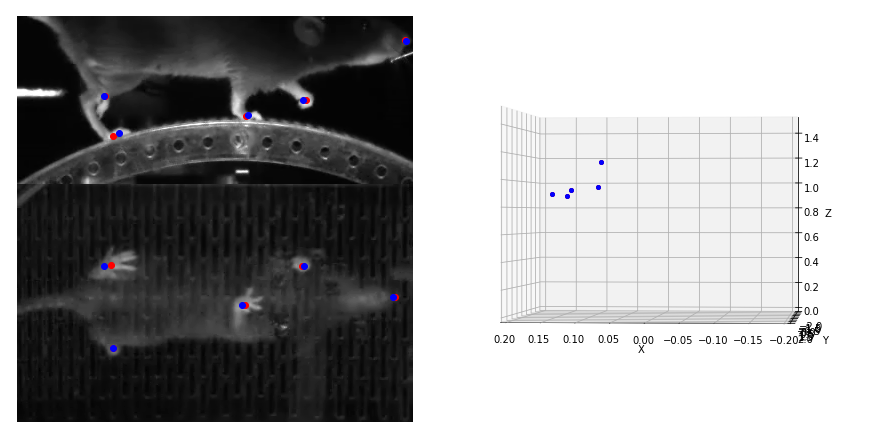

In [78]:
#### 3d plot
from matplotlib.gridspec import GridSpec
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1], projection = '3d') # https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html
image_folder = 'images_test'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

ax2.view_init(elev=0, azim=90) # see https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib

for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    ax2.cla()   
    # load image
    img = read_image(path_images[i], flip=False)

    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        ax = ax1, top_img_height=TOP_IMG_HEIGHT)
    
    ax2.azim += 1

    plot_3d_points(joined_list_3d,
                   lims,
                   i,
                   color_list_3d,
                   ax=ax2)
    im_int = str('%.5i' % i)
    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')
    #plt.show()
    
    


In [79]:
im_list = os.listdir(image_folder)
im_list.sort()
im_list = im_list[1:]
 
img_array = []
for filename in im_list:
    img = cv2.imread(os.path.join(image_folder, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('reconstruction.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 
                      5, size) # 15 fps
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


In [80]:
pts_dict2d_dlc = revert_ordered_arr_2d_to_dict(len(short_list), 2, pts_array_2d)

In [81]:
pts_dict2d_dlc[0]["x_coords"].shape

(7, 956)

# Computing Fundamental Matrix

In [82]:
from scipy.spatial.transform import Rotation as R
#Bundle adjustment code: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html

# Get rotation vector
rot_vec_1 = R.from_rotvec(camera_1.get_rotation())
R1 = rot_vec_1.as_matrix()
print("R1: ", R1)
#Get translation vector
t1 = camera_1.get_translation()
print('t1: ', t1)

#Get intrinsic matrix
K1 = camera_1.get_camera_matrix()

# Get rotation vector
rot_vec_2 = R.from_rotvec(camera_2.get_rotation())
R2 = rot_vec_2.as_matrix()
print("R2: ", R2)
#Get translation vector
t2 = camera_2.get_translation()
print('t2: ', t2)

#Get intrinsic matrix
K2 = camera_2.get_camera_matrix()

# --- Now compute relevant quantities for F estimation ------
#Camera matrix basics: http://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
#Fundamental matrix computation: https://rb.gy/dd0nz2

#Compute projection matrices
P1 = np.matmul(K1, np.concatenate((R1, t1[:, np.newaxis]), axis=1))
P2 = np.matmul(K2, np.concatenate((R2, t2[:, np.newaxis]), axis=1))

#Get camera center (view 1)
R1_inv = np.linalg.inv(R1) 
C = np.matmul(-R1_inv, t1)
C = np.append(C, 1)

F = np.matmul(skew(np.matmul(P2, C)), np.matmul(P2, np.linalg.pinv(P1)))
print('F: ', F)

R1:  [[ 0.83377685  0.34015238  0.43487069]
 [-0.53345113  0.69933908  0.47576753]
 [-0.14228861 -0.62866622  0.76454741]]
t1:  [-0.5431124  -0.57703591 -0.28108051]
R2:  [[ 0.93281892 -0.33709439  0.127343  ]
 [-0.08936272  0.12594733  0.98800383]
 [-0.34908907 -0.93300838  0.08736238]]
t2:  [ 0.03245243 -0.86715417  0.3872827 ]
F:  [[ 0.00489759  0.00272831 -0.3444086 ]
 [ 0.00687229  0.00153426 -0.19215154]
 [ 0.03914894 -0.00761814  0.98124364]]


In [83]:
epipolar_folder = './epipolar_lines/'
if not os.path.exists(epipolar_folder):
    os.makedirs(epipolar_folder)

for i in range(ind_start,ind_end):
    # load image
    img = read_image(path_images[i], flip=False)
    top_img = (img[0:TOP_IMG_HEIGHT, :] * 255).astype(np.uint8)
    bottom_img = (img[TOP_IMG_HEIGHT:, :] * 255).astype(np.uint8)
    
    #Recall, indices 0 and 2 correspond to bottom image
    x_t = joined_list_2d[1]['x_coords'][i][:,np.newaxis]
    y_t = joined_list_2d[1]['y_coords'][i][:,np.newaxis]

    x_b = joined_list_2d[0]['x_coords'][i][:,np.newaxis]
    y_b = joined_list_2d[0]['y_coords'][i][:,np.newaxis]

    points_top = np.concatenate((x_t,y_t), axis=1)
    points_bot = np.concatenate((x_b,y_b), axis=1)

    
    #Get rid of nans
    
    points_bot = points_bot.astype(np.int32)
    points_bot = points_bot[~np.isnan(points_bot).any(axis=1)]

    points_top = points_top.astype(np.int32)
    points_top = points_top[~np.isnan(points_top).any(axis=1)]


    top_img_with_points = draw_circles(top_img, points_top)
    bot_img_with_points = draw_circles(bottom_img, points_bot)
    #cv2.imwrite('epipolar_lines/top_image_points.jpg', top_img_with_points)
    #cv2.imwrite('epipolar_lines/bot_image_points.jpg', bot_img_with_points)

    #Homogenize points
    ones = np.ones(points_top.shape[0])[:,np.newaxis]
    points_top_homog = np.concatenate((points_top, ones), axis=-1)
    points_bot_homog = np.concatenate((points_bot, ones), axis=-1)
    
    aug_F = np.tile(F, (points_top_homog.shape[0], 1, 1))
    lines_bot = np.squeeze(np.matmul(aug_F, points_top_homog[:,:,np.newaxis]))
    #This^ gives us lines as vectors [a,b,c] --> ax + by + c = 0

    for line_vec in lines_bot:
        #Get x and y intercepts (on image) to plot

        #y = 0: x = -c/a
        x_intercept = int(-line_vec[2] / line_vec[0])
        #x = 0: y = -c/b
        y_intercept = int(-line_vec[2] / line_vec[1])
        bottom_img = drawLine(bottom_img, x_intercept, 0, 0, y_intercept)
        #bottom_img = cv2.line(bottom_img, (x_intercept, 0), (0, y_intercept), (255, 255, 255), thickness=1)



    cv2.imwrite(f'epipolar_lines/bot_{i}.jpg', bottom_img)


In [84]:
im_list = os.listdir(epipolar_folder)
im_list.sort()
im_list = im_list[1:]
 
img_array = []
for filename in im_list:
    img = cv2.imread(os.path.join(epipolar_folder, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    
out = cv2.VideoWriter('epipolar_video.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 
                      5, size) # 15 fps
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


# Plot camera coordinate systems

In [91]:
only_new=False
only_orig=False


#Test initialization
rot_vec_3 = R.from_rotvec([0, 0, 0])
R3 = rot_vec_3.as_matrix()
t3 = [0, 0, 0]

rot_vec_4 = R.from_rotvec(-np.pi/2 * np.array([1, 0, 0]))
R4 = rot_vec_4.as_matrix()
t4 = [0, -1, 1]

scale_factor=0.5

# Annotate cameras (origins and vectors)
data_1 = vector_plot([scale_factor*R1[:,0],scale_factor*R1[:,1],scale_factor*R1[:,2]], orig=t1,cam_name='1_new')
data_2 = vector_plot([scale_factor*R2[:,0],scale_factor*R2[:,1],scale_factor*R2[:,2]], orig=t2, cam_name='2_new')

data_3 = vector_plot([scale_factor*R3[:,0],scale_factor*R3[:,1],scale_factor*R3[:,2]], orig=t3, cam_name='1_og')
data_4 = vector_plot([scale_factor*R4[:,0],scale_factor*R4[:,1],scale_factor*R4[:,2]], orig=t4, cam_name='2_og')

#print(pts_array_3d_clean.shape)

data_5  = [go.Scatter3d(x=points_3d_init[:,0], y=points_3d_init[:,1], z=points_3d_init[:,2], mode='markers', marker=dict(size=2))]
#data_5  = [go.Scatter3d(x=optim_3d_pts_total[:,0], y=optim_3d_pts_total[:,1], z=optim_3d_pts_total[:,2], mode='markers', marker=dict(size=2))]
#data_5  = [go.Scatter3d(x=pts_array_3d_clean[:,0], y=pts_array_3d_clean[:,1], z=pts_array_3d_clean[:,2], mode='markers', marker=dict(size=2))]
layout = go.Layout(
            margin = dict(l = 4,
                        r = 4,
                        b = 4,
                        t = 4)
                )
if only_new:
        data = data_1 + data_2 + data_5
elif only_orig:
        data = data_3 + data_4 + data_5
else:
        data = data_1 + data_2 + data_3 + data_4 + data_5


fig = go.Figure(data=data,layout=layout)
fig.update_traces(textfont_size=6)

fig.show()

In [85]:
only_new=False
only_orig=False


#Test initialization
rot_vec_3 = R.from_rotvec([0, 0, 0])
R3 = rot_vec_3.as_matrix()
t3 = [0, 0, 0]

rot_vec_4 = R.from_rotvec(-np.pi/2 * np.array([1, 0, 0]))
R4 = rot_vec_4.as_matrix()
t4 = [0, -1, 1]

scale_factor=0.5

# Annotate cameras (origins and vectors)
data_1 = vector_plot([scale_factor*R1[:,0],scale_factor*R1[:,1],scale_factor*R1[:,2]], orig=t1,cam_name='1_new')
data_2 = vector_plot([scale_factor*R2[:,0],scale_factor*R2[:,1],scale_factor*R2[:,2]], orig=t2, cam_name='2_new')

data_3 = vector_plot([scale_factor*R3[:,0],scale_factor*R3[:,1],scale_factor*R3[:,2]], orig=t3, cam_name='1_og')
data_4 = vector_plot([scale_factor*R4[:,0],scale_factor*R4[:,1],scale_factor*R4[:,2]], orig=t4, cam_name='2_og')

#print(pts_array_3d_clean.shape)

data_5  = [go.Scatter3d(x=points_3d[:,0], y=points_3d[:,1], z=points_3d[:,2], mode='markers', marker=dict(size=2))]
#data_5  = [go.Scatter3d(x=optim_3d_pts_total[:,0], y=optim_3d_pts_total[:,1], z=optim_3d_pts_total[:,2], mode='markers', marker=dict(size=2))]
#data_5  = [go.Scatter3d(x=pts_array_3d_clean[:,0], y=pts_array_3d_clean[:,1], z=pts_array_3d_clean[:,2], mode='markers', marker=dict(size=2))]
layout = go.Layout(
            margin = dict(l = 4,
                        r = 4,
                        b = 4,
                        t = 4)
                )
if only_new:
        data = data_1 + data_2 + data_5
elif only_orig:
        data = data_3 + data_4 + data_5
else:
        data = data_1 + data_2 + data_3 + data_4 + data_5


fig = go.Figure(data=data,layout=layout)
fig.update_traces(textfont_size=6)

fig.show()

# Triangulate w/ temporal constraint

In [86]:
n_joints = pose_list_2d_orig[0]['x_coords'].shape[-1]
n_frames = pose_list_2d_orig[0]['x_coords'].shape[0]

points_2d_triangulate = np.empty((info_dict["num_cameras"], n_frames, n_joints, 2))
for i, pose_dict in enumerate(pose_list_2d_orig):
    x_coord = pose_dict['x_coords']
    y_coord = pose_dict['y_coords']
    coord_slice = np.transpose(np.asarray([x_coord, y_coord]), axes=(1, 2, 0))

    points_2d_triangulate[i] = coord_slice

In [108]:
optim_3d_pts = cam_group.triangulate_optim(points_2d_triangulate, scale_smooth=0.05)
optim_3d_pts_total = np.reshape(optim_3d_pts, (optim_3d_pts.shape[0] * optim_3d_pts.shape[1], optim_3d_pts.shape[2]))

In [109]:
points_2d_reproj_triang = np.concatenate((camera_1.project(optim_3d_pts_total).squeeze(), camera_2.project(optim_3d_pts_total).squeeze()), axis=0)
pose_list_2d_triang_reproj =  arr_2d_to_list_of_dicts(points_2d_reproj_triang, info_dict)
joined_list_2d_triang = pose_list_2d_orig + pose_list_2d_triang_reproj


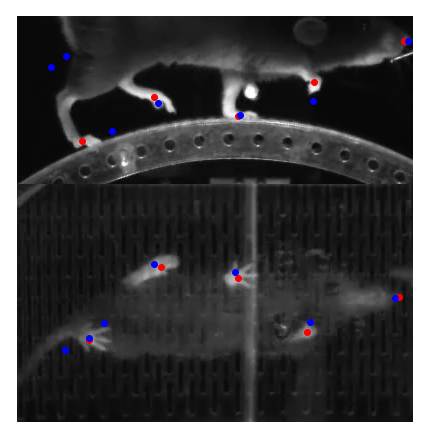

In [110]:
#### 3d plot
from matplotlib.gridspec import GridSpec
import mpl_toolkits.mplot3d.axes3d as p3
from utils.utils_plotting import plot_image_labels, plot_3d_points

%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
image_folder = 'images_test'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

ax2.view_init(elev=0, azim=90) # see https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib

for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    # load image
    img = read_image(path_images[i], flip=False)

    plot_image_labels(img,\
                        joined_list_2d_triang,
                        i,
                        color_list_2d,
                        ax = ax1, top_img_height=TOP_IMG_HEIGHT)
    
    ax2.azim += 1

    plt.show()

In [111]:
only_new=False
only_orig=False


#Test initialization
rot_vec_3 = R.from_rotvec([0, 0, 0])
R3 = rot_vec_3.as_matrix()
t3 = [0, 0, 0]

rot_vec_4 = R.from_rotvec(-np.pi/2 * np.array([1, 0, 0]))
R4 = rot_vec_4.as_matrix()
t4 = [0, -1, 1]

scale_factor=0.5

# Annotate cameras (origins and vectors)
data_1 = vector_plot([scale_factor*R1[:,0],scale_factor*R1[:,1],scale_factor*R1[:,2]], orig=t1,cam_name='1_new')
data_2 = vector_plot([scale_factor*R2[:,0],scale_factor*R2[:,1],scale_factor*R2[:,2]], orig=t2, cam_name='2_new')

data_3 = vector_plot([scale_factor*R3[:,0],scale_factor*R3[:,1],scale_factor*R3[:,2]], orig=t3, cam_name='1_og')
data_4 = vector_plot([scale_factor*R4[:,0],scale_factor*R4[:,1],scale_factor*R4[:,2]], orig=t4, cam_name='2_og')

#print(pts_array_3d_clean.shape)

#data_5  = [go.Scatter3d(x=points_3d[:,0], y=points_3d[:,1], z=points_3d[:,2], mode='markers', marker=dict(size=2))]
data_5  = [go.Scatter3d(x=optim_3d_pts_total[:,0], y=optim_3d_pts_total[:,1], z=optim_3d_pts_total[:,2], mode='markers', marker=dict(size=2))]
#data_5  = [go.Scatter3d(x=pts_array_3d_clean[:,0], y=pts_array_3d_clean[:,1], z=pts_array_3d_clean[:,2], mode='markers', marker=dict(size=2))]
layout = go.Layout(
            margin = dict(l = 4,
                        r = 4,
                        b = 4,
                        t = 4)
                )
if only_new:
        data = data_1 + data_2 + data_5
elif only_orig:
        data = data_3 + data_4 + data_5
else:
        data = data_1 + data_2 + data_3 + data_4 + data_5


fig = go.Figure(data=data,layout=layout)
fig.update_traces(textfont_size=6)

fig.show()